In [ ]:
from google.colab import files
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Upload dataset
files.upload()

In [ ]:
v= pd.read_csv("y_dataset.csv")
h= pd.read_csv("x_dataset.csv")
vnum=v.to_numpy()
hnum=h.to_numpy()
vnum=vnum.astype(np.float32)
hnum=hnum.astype(np.float32)
## train_test_split ##
train,test = train_test_split(vnum,test_size=0.2,random_state=42)

In [ ]:
def plot_image(x,y,n):
  plt.figure(figsize=(20,1))
  plt.scatter(x,y)
  plt.plot(x,y)
  plt.axis('off')
  plt.title(f"{n}")
  plt.show()

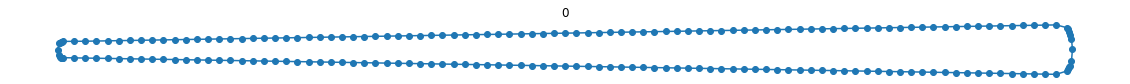

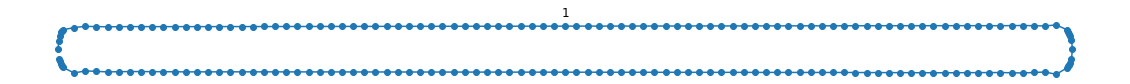

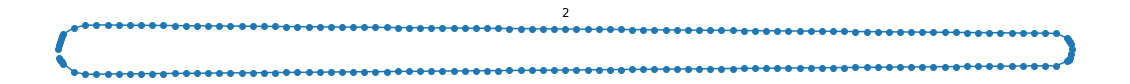

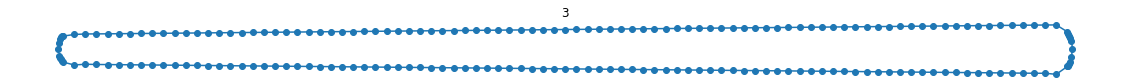

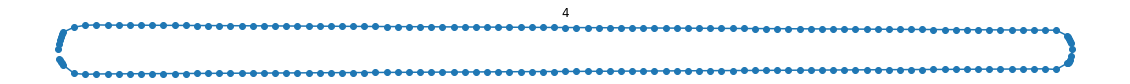

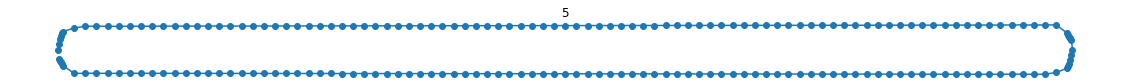

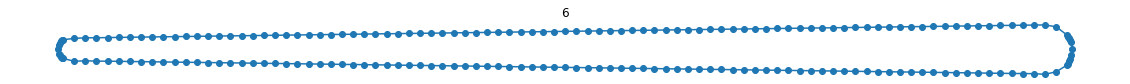

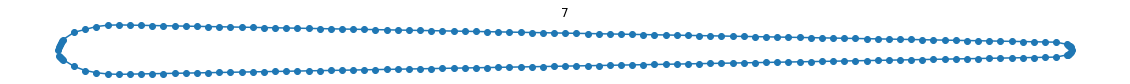

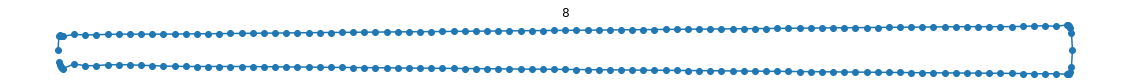

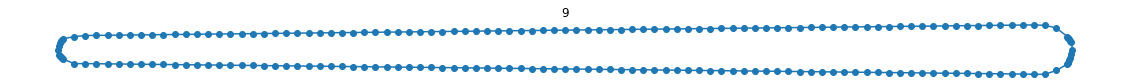

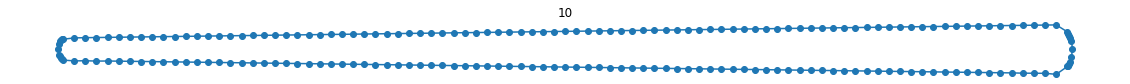

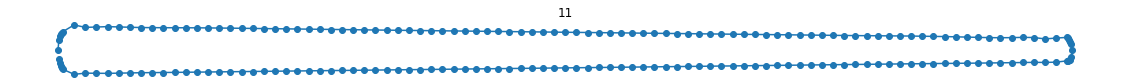

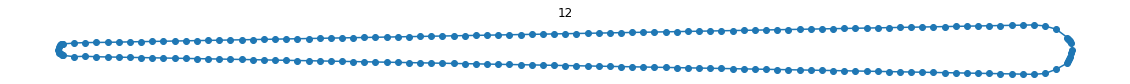

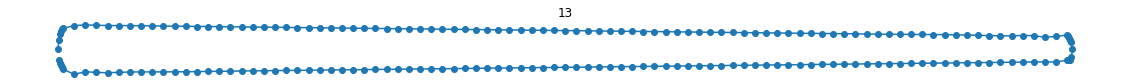

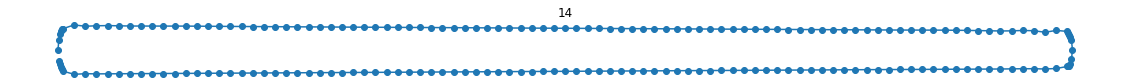

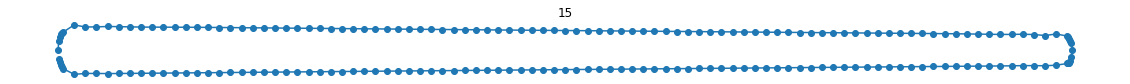

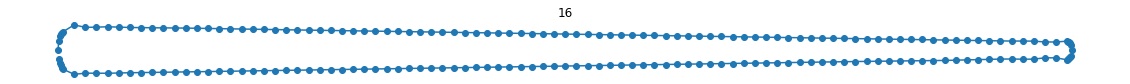

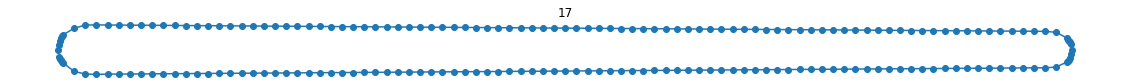

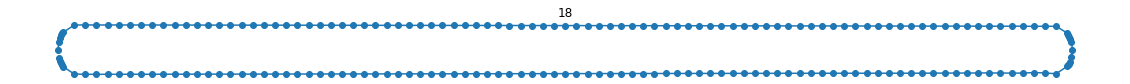

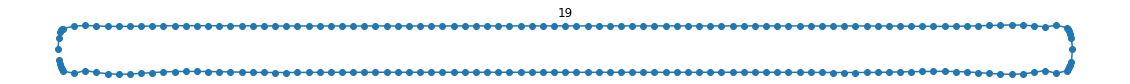

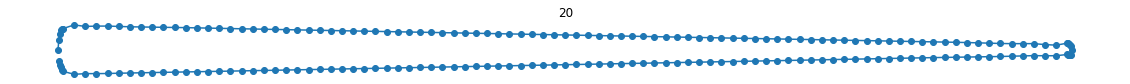

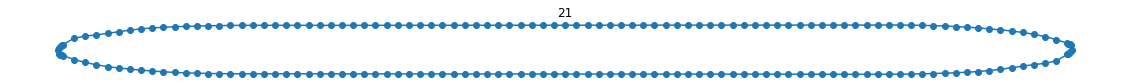

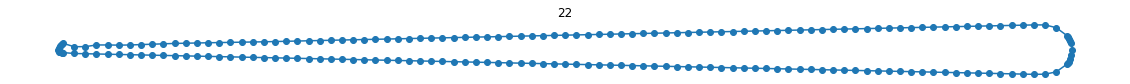

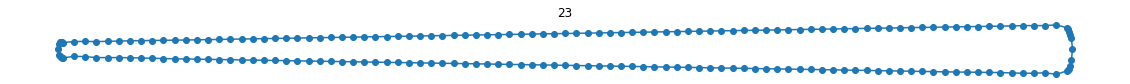

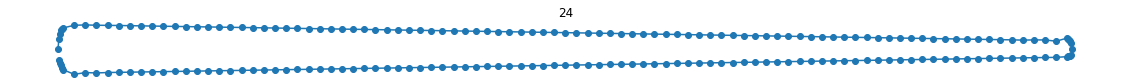

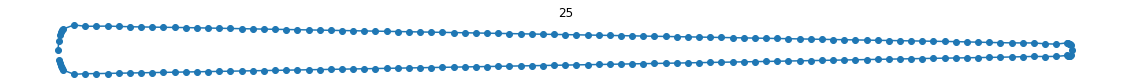

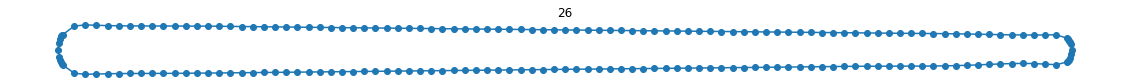

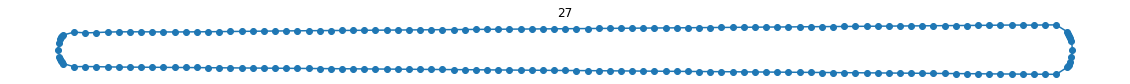

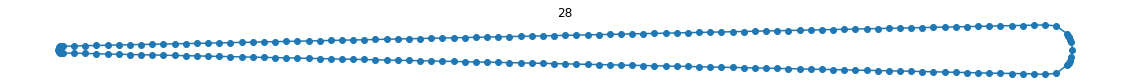

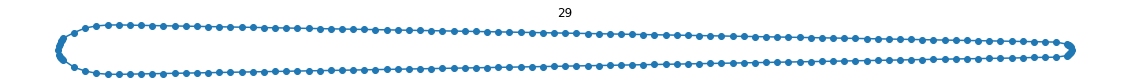

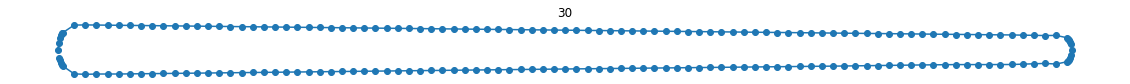

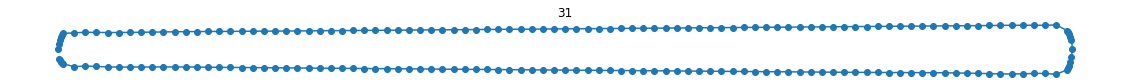

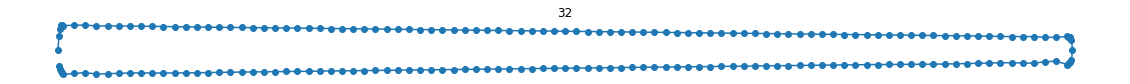

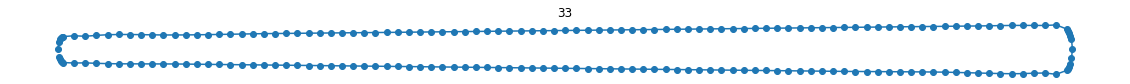

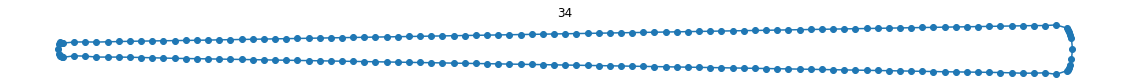

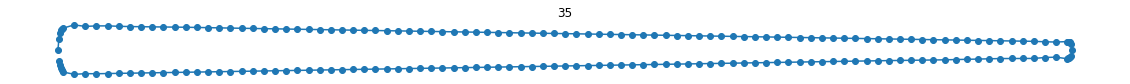

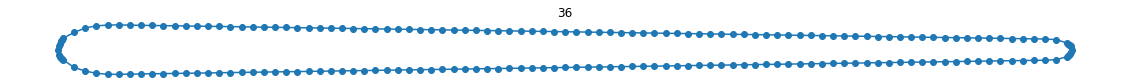

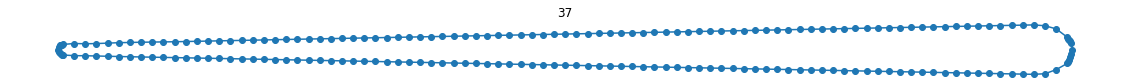

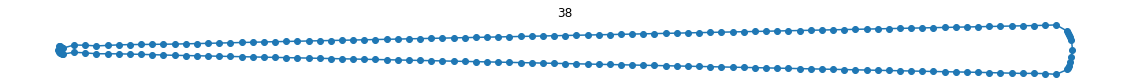

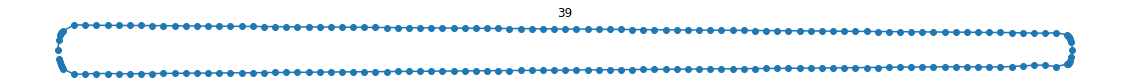

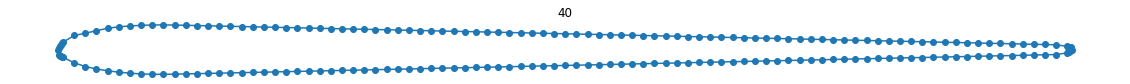

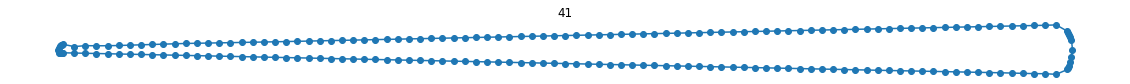

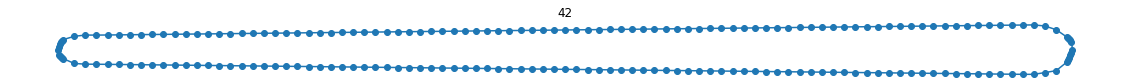

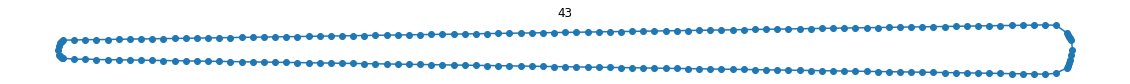

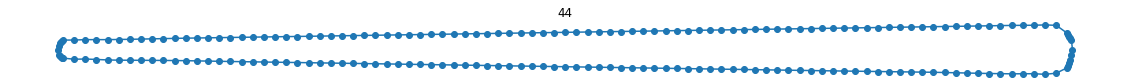

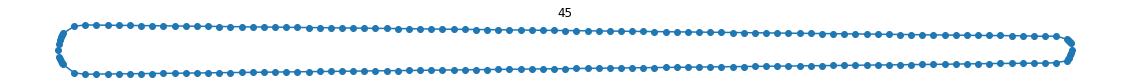

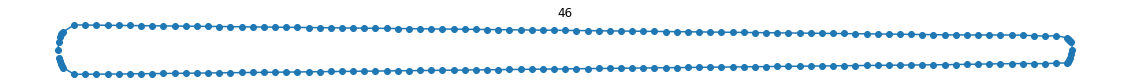

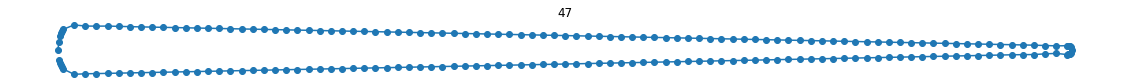

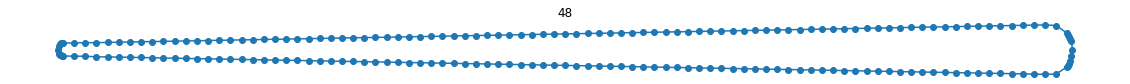

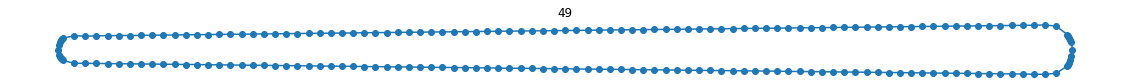

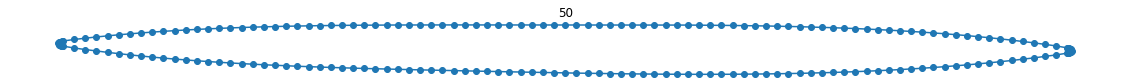

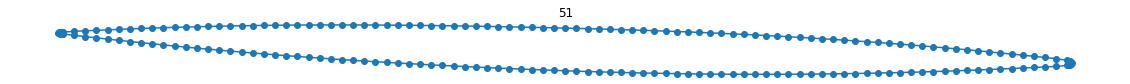

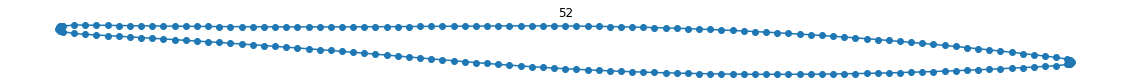

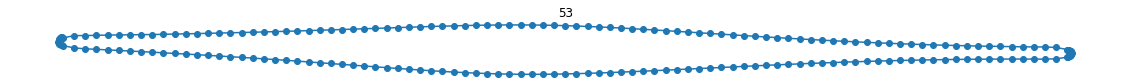

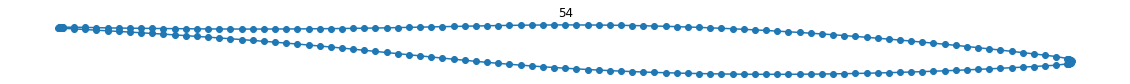

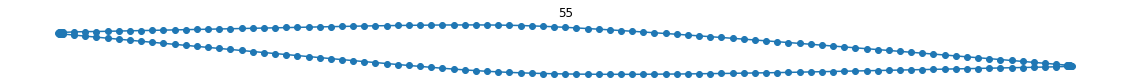

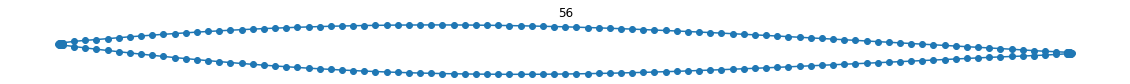

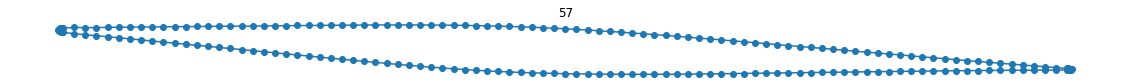

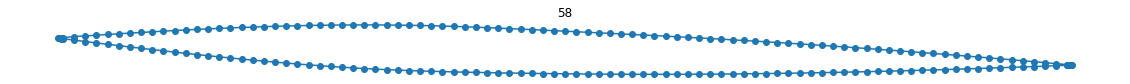

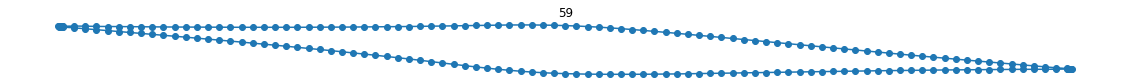

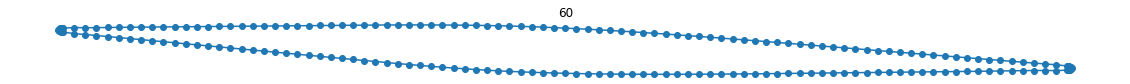

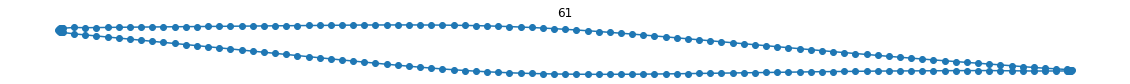

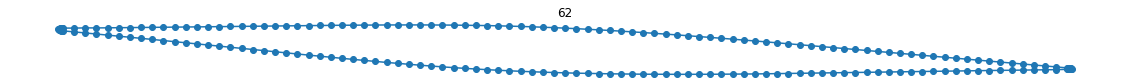

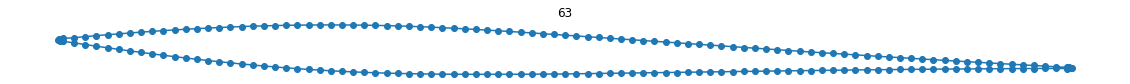

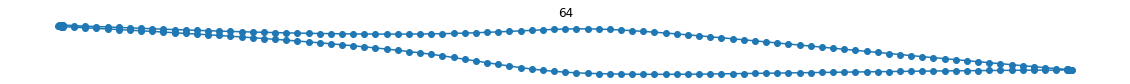

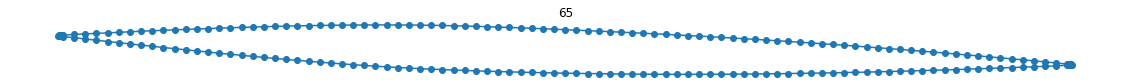

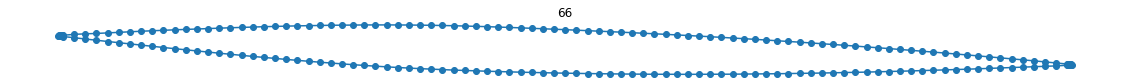

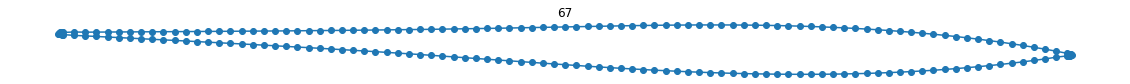

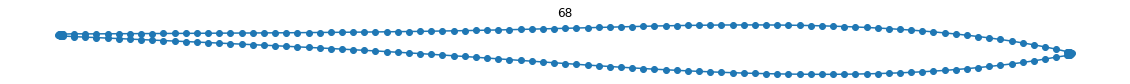

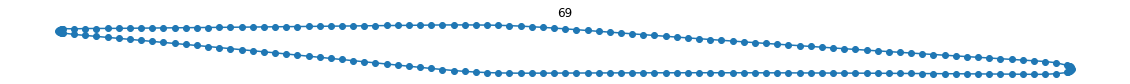

In [ ]:
for n in range(70):
  plot_image(hnum[0],vnum[n],n)

In [ ]:
class Sampling(keras.layers.Layer):
  def call(self,inputs):
    mean,log_var=inputs
    return keras.backend.random_normal(shape= tf.shape(log_var)) * keras.backend.exp(log_var/2) + mean

In [ ]:
class layer(keras.layers.Layer):
  def call(self,input):
    list1=[]
    list2=[]
    if input.shape[0]:
      for n in range (input.shape[0]):
        x=input[n]
        for i,lay in enumerate(discriminator.layers):
          x=tf.reshape(x,[1,-1])
          if i==0:
            x=lay(x)
            mean1=keras.backend.mean(x)
            list1.append(mean1)
          elif i==1:
            x=lay(x)
            mean2=keras.backend.mean(x)
            list2.append(mean2)
          else:
            break
            
      out1=tf.stack(list1)
      out2=tf.stack(list2)
      return out1, out2

In [ ]:

codings_size=10
### Encoder
inputs=keras.layers.Input(shape=(200,))
z=keras.layers.Dense(150, activation=keras.layers.LeakyReLU(alpha=0.1))(inputs)
z=keras.layers.Dense(100, activation=keras.layers.LeakyReLU(alpha=0.1))(z)
codings_mean=keras.layers.Dense(codings_size)(z)
codings_log_var=keras.layers.Dense(codings_size)(z)
codings=Sampling()([codings_mean,codings_log_var])
encoder=keras.models.Model(inputs=[inputs],outputs=[codings])
### Decoder
decoder_inputs=keras.layers.Input(shape=[codings_size])
x=keras.layers.Dense(100,activation=keras.layers.LeakyReLU(alpha=0.1))(decoder_inputs)
x=keras.layers.Dense(150,activation=keras.layers.LeakyReLU(alpha=0.1))(x)
outputs=keras.layers.Dense(200,activation="tanh")(x)
decoder=keras.models.Model(inputs=[decoder_inputs],outputs=[outputs])

### Discriminator
discriminator=keras.models.Sequential([
    keras.layers.Dense(150, activation=keras.layers.LeakyReLU(alpha=0.1), input_shape=(200,)),
    keras.layers.Dense(100, activation=keras.layers.LeakyReLU(alpha=0.1)),
    keras.layers.Dense(1, activation="sigmoid")
])
                ### loss and compile ###     
optimizer=keras.optimizers.Adam(learning_rate=0.0005)
### 0. Discriminator ###
# discriminator.load_weights("weights_dis_5_70.h5")
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
discriminator.trainable=False
### 1. VAE ###
# decoder.load_weights("weights_dec_5_70.h5")
# encoder.load_weights("weights_enc_5_70.h5")
codings=encoder(inputs)
reconstructions=decoder(codings)
vae=keras.models.Model(inputs=[inputs], outputs=[reconstructions])
## prior_loss
prior_loss= -0.5* keras.backend.sum(1 + codings_log_var - keras.backend.exp(codings_log_var) - keras.backend.square(codings_mean), axis=-1)
prior_loss=keras.backend.mean(prior_loss)/200.

vae.add_loss(prior_loss)
vae.compile(loss="mean_squared_error", optimizer=optimizer)
### 2. GAN ###
gan=keras.models.Sequential([decoder,discriminator])
### 3. vaeGan ###
## layer loss
output=layer()(vae(inputs))
vaeGan=keras.models.Model(inputs=[inputs],outputs=[output])
vaeGan.compile(loss= "mean_squared_error", optimizer=optimizer)

In [ ]:
n_epochs=5000 
batch_size=5
buffer_size=100
dataset=tf.data.Dataset.from_tensor_slices(train).shuffle(buffer_size=buffer_size)
datapoint=dataset.batch(batch_size=batch_size,drop_remainder=True).prefetch(1)

### Training ### 
for epoch in range(n_epochs):
  print("Epoch {}/{}".format(epoch+1,n_epochs))
  for x_batch in datapoint:
    ##### Discriminator training #####
    noise=tf.random.normal(shape=[batch_size,codings_size])
    fake_sample=decoder(noise)
    reconstructed_sample= vae(x_batch)

    fake_copy_real=tf.concat([fake_sample,reconstructed_sample,x_batch], axis=0)
    label_d=tf.constant([[0.]]*batch_size+[[0.]]*batch_size + [[1.]]*batch_size)
    discriminator.trainable=True
    loss_dis=discriminator.train_on_batch(fake_copy_real,label_d)
    
    ##### Generator training #####
    discriminator.trainable=False
    ### training vae
    loss_vae=vae.train_on_batch(x_batch,x_batch)
    ### training vaeGan
    layer_real=layer()(x_batch)
    
    noise=tf.random.normal(shape=[batch_size, codings_size])
    fake=decoder(noise)
    loss_fake=vaeGan.train_on_batch(fake,layer_real)
    loss_recon=vaeGan.train_on_batch(x_batch,layer_real)
discriminator.save_weights("weights_dis_5_70.h5")
decoder.save_weights("weights_dec_5_70.h5")
encoder.save_weights("weights_enc_5_70.h5")

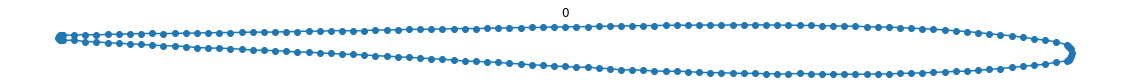

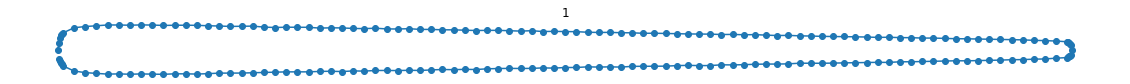

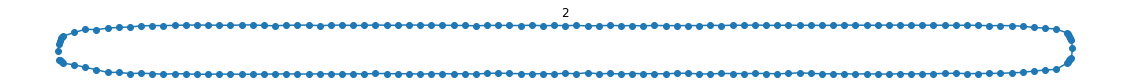

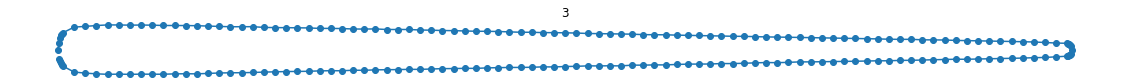

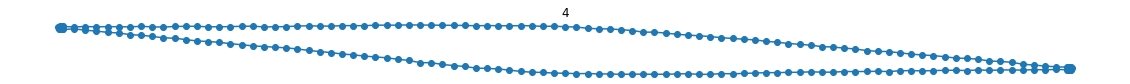

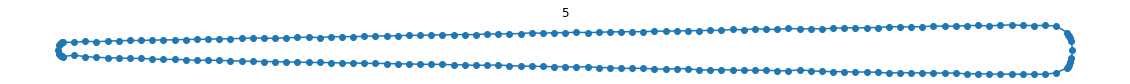

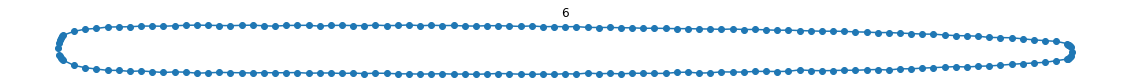

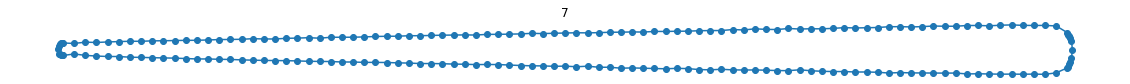

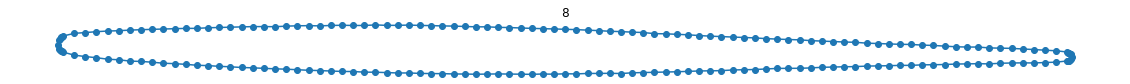

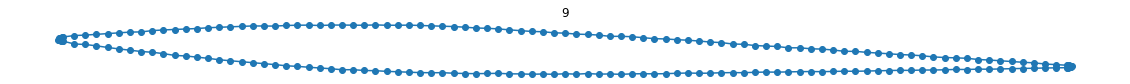

In [ ]:
## Generate random samples
for n in range(10):
      noise=tf.random.normal(shape=[1,codings_size],seed=n)
      generated_image=decoder(noise)
      generated_image=tf.reshape(generated_image,[200])
      plot_image(hnum[0],generated_image,n)  

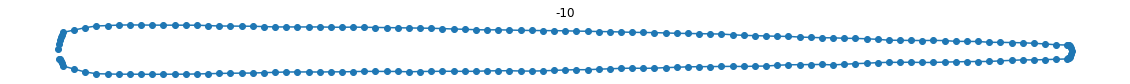

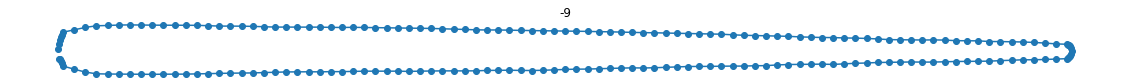

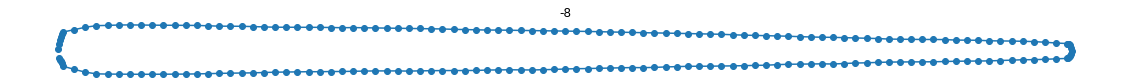

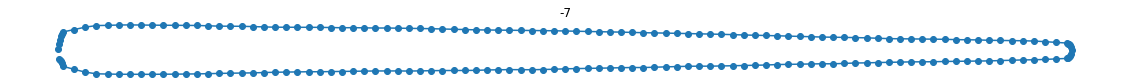

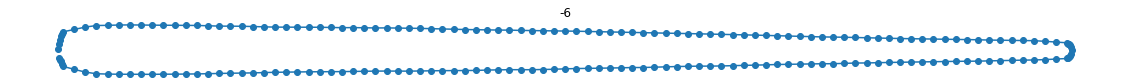

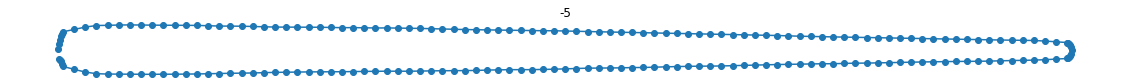

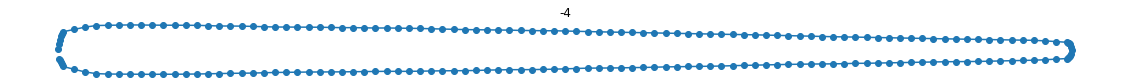

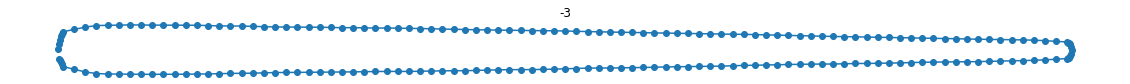

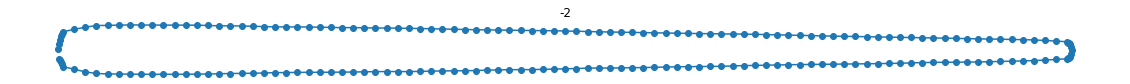

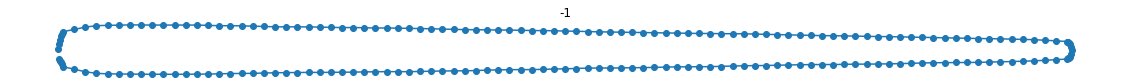

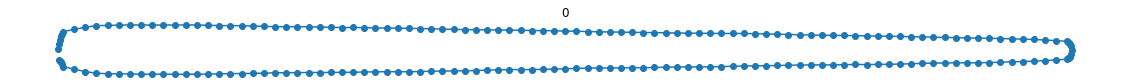

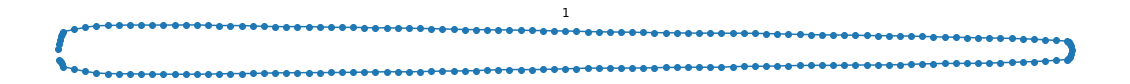

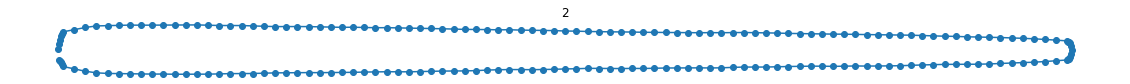

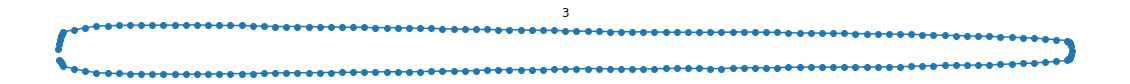

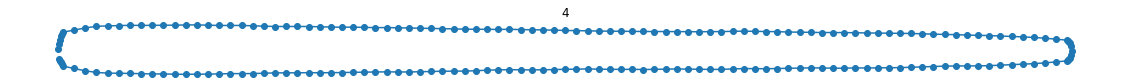

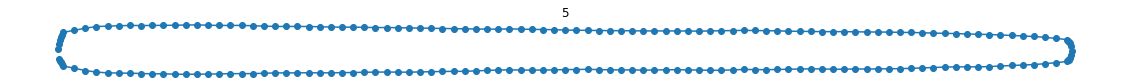

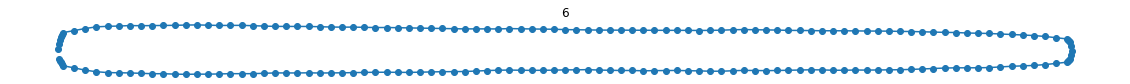

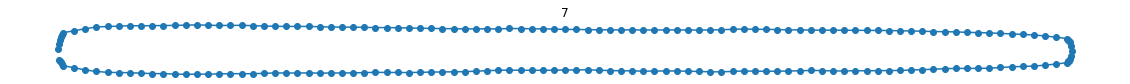

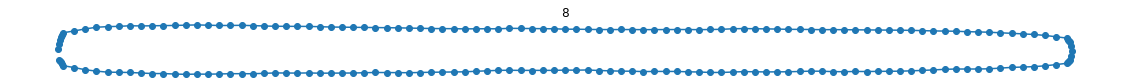

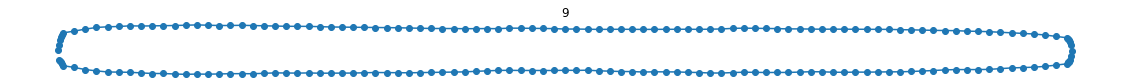

In [ ]:
# Manual changes
noise=np.zeros(codings_size)
noise=noise.reshape(1,-1)
for i in range(-10,10):
  noise[0][9]=i   # 1, 4, 7, 9
  random_sample=decoder(noise)
  random_sample=tf.reshape(random_sample,[200])
  random_sample=savgol_filter(random_sample, window_length= 7, polyorder=2 )
  plot_image(hnum[0],random_sample,i)

In [ ]:
from numpy.random import randint, rand

feature_domain=encoder(train)

def interpolate(n_pop,feature_domain):
  for n in randint(0,len(feature_domain),n_pop):
    z1=feature_domain[n]
    m= randint(0,len(feature_domain))
    if m==n:
      m+=1
    z2=feature_domain[m]
    neu=rand()
    z3=neu*z1+(1-neu)*z2

    z1=np.array(z1).reshape(1,-1)
    x1=decoder(z1)
    x1=tf.reshape(x1,[200])
        
    z2=np.array(z2).reshape(1,-1)
    x2=decoder(z2)
    x2=tf.reshape(x2,[200])
    
    z3=np.array(z3).reshape(1,-1)
    interpolated=decoder(z3)
    interpolated=tf.reshape(interpolated,[200])
    
    plot_image(hnum[0],x1,n)
    plot_image(hnum[0],x2,m)
    plot_image(hnum[0],interpolated,[n,m])

####################

def extrapolate(n_pop,feature_domain):
  for n in randint(0,len(feature_domain),n_pop):
    z1=feature_domain[n]
    m= randint(0,len(feature_domain))
    if m==n:
      m+=1
    z2=feature_domain[m]
    neu=-rand()
    z3=neu*z1+(1-neu)*z2
    
    z1=np.array(z1).reshape(1,-1)
    x1=generator(z1)
    x1=tf.reshape(x1,[200])
        
    z2=np.array(z2).reshape(1,-1)
    x2=generator(z2)
    x2=tf.reshape(x2,[200])
    
    z3=np.array(z3).reshape(1,-1)
    extrapolated=generator(z3)
    extrapolated=tf.reshape(extrapolated,[200])
    
    plot_image(hnum[0],x1,n)
    plot_image(hnum[0],x2,m)
    plot_image(hnum[0],extrapolated,[n,m])

interpolated


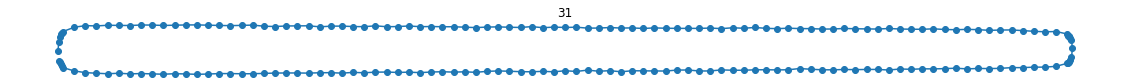

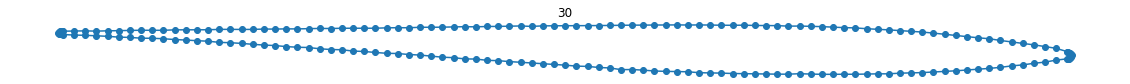

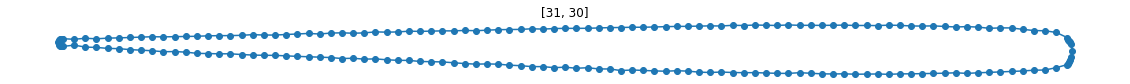

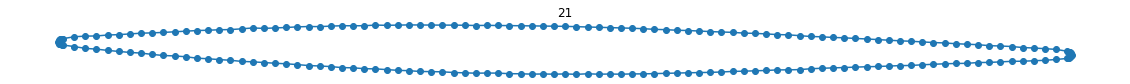

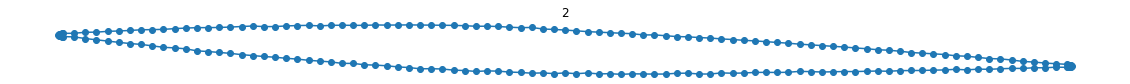

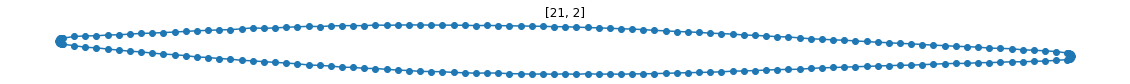

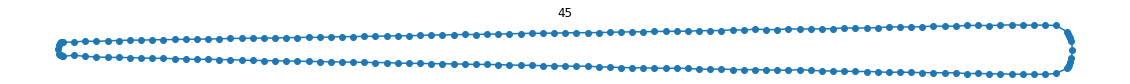

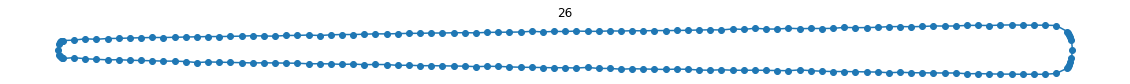

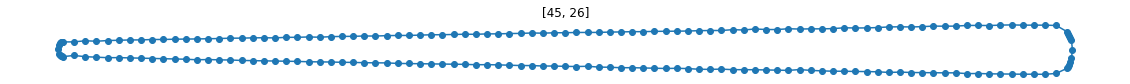

extrapolated


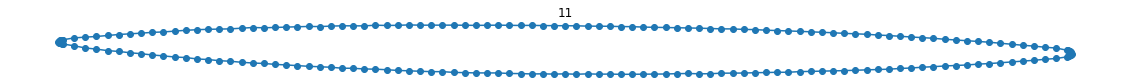

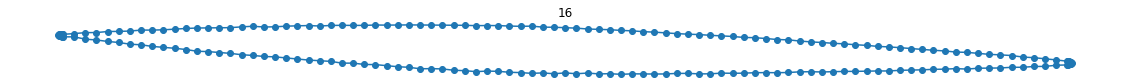

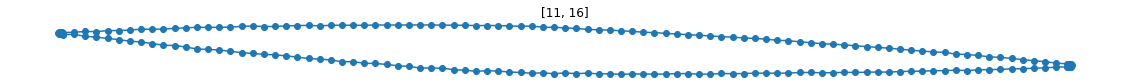

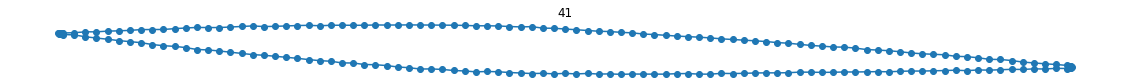

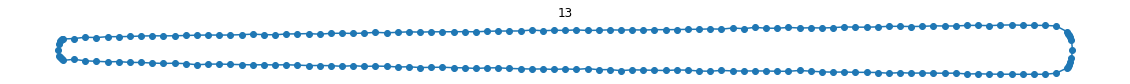

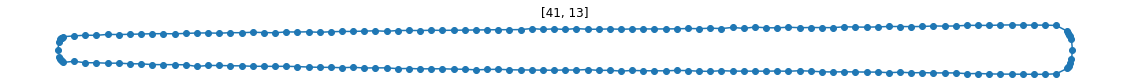

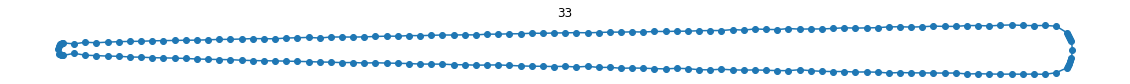

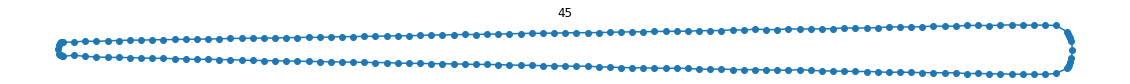

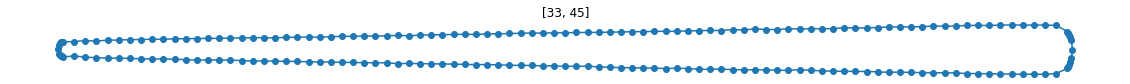

In [ ]:
n_pop=3
print("interpolated")
interpolate(n_pop,feature_domain)
print("extrapolated")
extrapolate(n_pop,feature_domain)